In [0]:
from torch import optim
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torchvision import transforms, models
import numpy as np
import os
import matplotlib.pyplot as plt

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive')
test_dir = 'drive/My Drive/ICV_Project/tests'
styled_dir = 'drive/My Drive/ICV_Project/styled'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Utils

In [0]:
def load_image(img_path, img_size=None):
    image = Image.open(img_path)
    if img_size is not None:
        image = image.resize((img_size, img_size))
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image


def im_convert(tensor):
    image = tensor.to("cpu").clone().detach().numpy().squeeze(0).transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# High-Resolution Generation Network

In [0]:
class BottleneckRes(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckRes, self).__init__()
        
        wrapped_out = out_channels // 4
        momentum = 0.1
        
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, wrapped_out, kernel_size=1, stride=1, padding=0),
            nn.InstanceNorm2d(wrapped_out, momentum=momentum),
            nn.ReLU(),
            
            nn.Conv2d(wrapped_out, wrapped_out, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(wrapped_out, momentum=momentum),
            nn.ReLU(),
            
            nn.Conv2d(wrapped_out, out_channels, kernel_size=1, stride=1, padding=0),
            nn.InstanceNorm2d(out_channels, momentum=momentum),
            nn.ReLU(),
        )
        
        self.right = None
        if in_channels != out_channels:
            self.right = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.InstanceNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return self.relu(out)


class HighResNet(nn.Module):
    def __init__(self):
        super(HighResNet, self).__init__()

        self.residual_in = BottleneckRes(3, 16)
        self.residual1_2 = BottleneckRes(16, 32)
        self.residual2_4 = BottleneckRes(32, 32)
        self.residual4_7 = BottleneckRes(64, 64)
        self.residual7_10 = BottleneckRes(192, 64)
        self.residual10_11 = BottleneckRes(64, 32)
        self.residual11_12 = BottleneckRes(32, 16)
        
        self.residual3_5 = BottleneckRes(32, 32)
        
        self.downsample1_3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.downsample2_5 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.downsample2_6 = nn.Conv2d(32, 32, kernel_size=3, stride=4, padding=1)
        
        self.downsample3_6 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        
        self.upsample3_4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample5_7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        self.upsample6_7 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

        self.out = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        fmap1 = self.residual_in(x)
        fmap2 = self.residual1_2(fmap1)
        fmap3 = self.downsample1_3(fmap1)
        fmap4 = torch.cat((self.residual2_4(fmap2), self.upsample3_4(fmap3)), 1)
        fmap5 = torch.cat((self.downsample2_5(fmap2), self.residual3_5(fmap3)), 1)
        fmap6 = torch.cat((self.downsample2_6(fmap2), self.downsample3_6(fmap3)), 1)
        fmap7 = torch.cat((self.residual4_7(fmap4), self.upsample5_7(fmap5), self.upsample6_7(fmap6)), 1)
        out = self.residual7_10(fmap7)
        out = self.residual10_11(out)
        out = self.residual11_12(out)
        out = self.out(out)
        return out

# Style Transfering

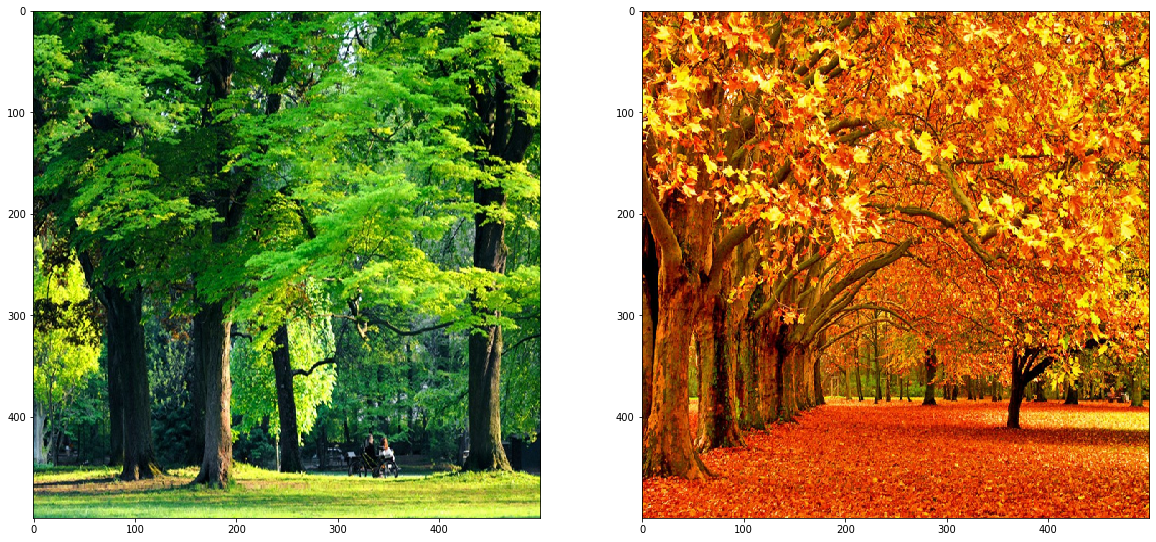

In [0]:
content_image = load_image('content.png')
content_image = content_image.to(device)
style_image = load_image('style.png')
style_image = style_image.to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))
plt.show()

In [0]:
class StyleTransfer:
    def __init__(self, content, style):
        self.content = content
        self.style = style
        
        self.high_res_net = HighResNet()
        self.high_res_net.to(device)
        
        self.VGG = models.vgg19(pretrained=True).features
        self.VGG.to(device)
        for parameter in self.VGG.parameters():
            parameter.requires_grad_(False)
        
    def get_features(self, image):
        features = {}
        image = image.clone()
        layers = {'0': 'conv1_1', 
                  '5': 'conv2_1',   
                  '10': 'conv3_1',  
                  '19': 'conv4_1',  
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
        for name, layer in self.VGG._modules.items():
            image = layer(image)
            if name in layers:
                features[layers[name]] = image
        return features
    
    def gram_matrix(self, tensor):
        B, C, H, W = tensor.size()
        tensor = tensor.view(B * C, H * W)
        GM = torch.mm(tensor, tensor.t())
        return GM
    
    def compute_loss(self, target, Cs, Cw):
        VGG_weights = {'conv1_1': 0.1,
                       'conv2_1': 0.2,
                       'conv3_1': 0.4,
                       'conv4_1': 0.8,
                       'conv5_1': 1.6}
        
        target_features = self.get_features(target)
        content_loss = torch.mean((target_features['conv4_2'] - self.content_features['conv4_2']) ** 2)
        style_loss = 0
        for layer in VGG_weights:
            target_feature = target_features[layer]
            target_gram_matrix = self.gram_matrix(target_feature)
            style_gram_matrix = self.style_gram_matrices[layer]
            layer_style_loss = VGG_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
            B, C, H, W = target_feature.shape
            style_loss += layer_style_loss / (C * H * W)
                
        self.loss = Cw * content_loss + Cs * style_loss
    
    def forward(self, epochs=500, Cs=1, Cw=80, learning_rate=5e-3):
        self.content_features = self.get_features(self.content)
        self.style_features = self.get_features(self.style)
        self.style_gram_matrices = {layer: self.gram_matrix(self.style_features[layer]) for layer in self.style_features}
        
        target = content_image.clone().requires_grad_(True).to(device)
        output = self.content
        optimizer = optim.Adam(self.high_res_net.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
        for epoch in range(epochs):            
            target = self.high_res_net.forward(content_image).to(device)
            target.requires_grad_(True)            
            
            self.compute_loss(target, Cs, Cw)
            optimizer.zero_grad()
            self.loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print("Epoch: ", epoch)
                print('Total loss: ', self.loss.item())
                plt.imshow(im_convert(target))
                plt.show()
            
            scheduler.step()
            output = target
        return output

Epoch:  0
Total loss:  2194.60546875


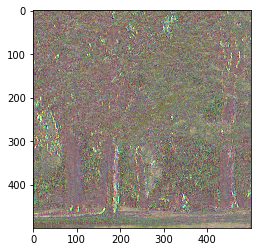

Epoch:  100
Total loss:  308.38763427734375


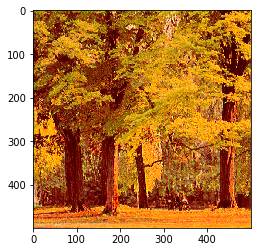

Epoch:  200
Total loss:  252.08547973632812


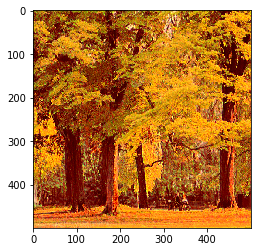

Epoch:  300
Total loss:  218.00006103515625


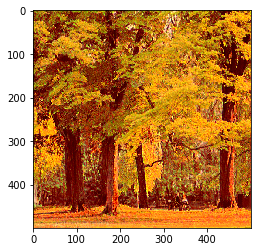

Epoch:  400
Total loss:  208.89605712890625


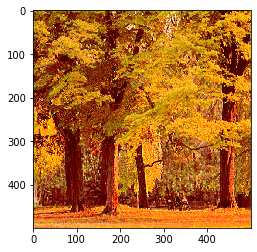

CPU times: user 2min 47s, sys: 2min 11s, total: 4min 58s
Wall time: 5min


In [0]:
%%time
ST = StyleTransfer(content_image, style_image)
output = ST.forward()

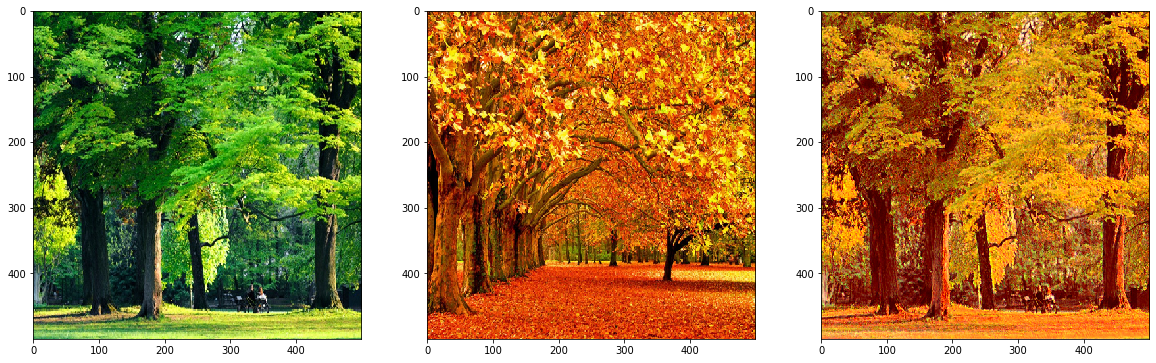

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))
ax3.imshow(im_convert(output))
plt.imsave('styled.jpg',im_convert(output))

plt.show()

In [0]:
for fruit in os.listdir(test_dir):
    style_image = load_image(test_dir + '/' + fruit + '/' + sorted(os.listdir(test_dir + '/' + fruit))[0]).to(device)
    print(f'fruit: {fruit}')
    count = 0
    for content in os.listdir(test_dir):
        print(f'content: {content}')
        if content == fruit: continue
        for img in os.listdir(test_dir + '/' + content):
            if count % 15 == 0:
                print(count)
            content_image = load_image(test_dir + '/' + content + '/' + img).to(device)
            ST = StyleTransfer(content_image, style_image)
            output = ST.forward(Cs=1, Cw=1)
            plt.imsave(styled_dir + '/' + fruit + '/' + str(count) + '.jpg',im_convert(output))
            count += 1

fruit: Cocos
CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 12.2 µs
content: Cocos
content: Orange
0
content: Apple
15
content: Banana
30
content: Lemon
45
fruit: Orange
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
content: Cocos
0
content: Orange
content: Apple
15
content: Banana
30
content: Lemon
45
fruit: Apple
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
content: Cocos
0
content: Orange
15
content: Apple
content: Banana
30
content: Lemon
45
fruit: Banana
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.34 µs
content: Cocos
0
content: Orange
15
content: Apple
30


In [0]:
import pickle

import torch
import torch.nn as nn
import torchvision.transforms as T

from PIL import Image


class FruitClassifier(nn.Module):

    def __init__(self, classes, id2class):
        super(FruitClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 64, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(5),
            nn.Flatten(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, classes)
        )
        self.id2class = id2class

    def forward(self, x):
        return self.model(x)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    def predict(self, x):
        return self.id2class[self.model(x).max(1)[1].cpu().item()]


def load_image_(filename, device='cpu'):
    transform = T.Compose([T.ToTensor(),
                           T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    img = Image.open(filename)
    img_t = transform(img)
    return img_t.unsqueeze(0).to(device)


with open('drive/My Drive/ICV_Project/id2class.pkl', 'rb') as fd:
    id2class = pickle.load(fd)

clf = FruitClassifier(5, id2class)
clf.load_weights('drive/My Drive/ICV_Project/fruit_classifier.pth')

In [0]:
acc = {}
for fruit in os.listdir(styled_dir):
    acc[fruit] = 0
    for picture in os.listdir(styled_dir + '/' +  fruit):
      img = load_image_(styled_dir + '/' +  fruit  + '/' + picture)
      if clf.predict(img) == fruit:
          acc[fruit] += 1
print(acc)

{'Apple': 26, 'Banana': 0, 'Cocos': 34, 'Orange': 45, 'Lemon': 45}


In [0]:
for key in acc:
    acc[key] /= 60
print(acc)

{'Apple': 0.43333333333333335, 'Banana': 0.0, 'Cocos': 0.5666666666666667, 'Orange': 0.75, 'Lemon': 0.75}
